In [1]:
import os, gc, re, time, pickle
from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
os.listdir('../data/input')

['.DS_Store',
 'calendar.csv',
 'sell_prices.csv',
 'sales_train_validation.csv',
 'sample_submission.csv']

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def read_data(nrows=55000000, merge=False):
    
    print('Reading files...')
    calendar = pd.read_csv('../data/input/calendar.csv')
    sell_prices = pd.read_csv('../data/input/sell_prices.csv')
    sales_train_validation = pd.read_csv('../data/input/sales_train_validation.csv')
    submission = pd.read_csv('../data/input/sample_submission.csv')
    
    # melt sales data, get it ready for training
    _ids = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    sales_train_validation = pd.melt(sales_train_validation, id_vars=_ids, var_name='day', value_name='demand')
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    d_col_1 = [f'd_{x}' for x in np.arange(1914, 1941+1, 1)]
    d_col_2 = [f'd_{x}' for x in np.arange(1942, 1969+1, 1)]
    d_col_1 = ['id'] + d_col_1
    d_col_2 = ['id'] + d_col_2
    
    test1.columns = d_col_1
    test2.columns = d_col_2
    del d_col_1, d_col_2
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    test1 = pd.melt(test1, id_vars=_ids, var_name='day', value_name='demand')
    test2 = pd.melt(test2, id_vars=_ids, var_name='day', value_name='demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis=0)
    
    del sales_train_validation, test1, test2
    gc.collect()
    
    # get only a sample for fst training
    if nrows is not None:
        data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace=True, axis=1)
    
    # delete test2 for now
#     data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how='left', left_on=['day'], right_on=['d'])
        data.drop(['d', 'day'], inplace=True, axis=1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    data['date'] = pd.to_datetime(data['date'].values)
    
    data = reduce_mem_usage(data)
    gc.collect()
    
    return data

In [4]:
%%time
df = read_data(nrows=None, merge=True)

Reading files...
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 60034810 rows and 18 columns
Mem. usage decreased to 6469.66 Mb (25.7% reduction)
CPU times: user 2min 40s, sys: 1min 39s, total: 4min 20s
Wall time: 4min 38s


In [5]:
with open('../data/input/data.pkl', 'wb') as f:
    pickle.dump(df, f)

In [7]:
df.dtypes

id                      object
item_id                 object
dept_id                 object
cat_id                  object
store_id                object
state_id                object
demand                   int16
part                    object
date            datetime64[ns]
wm_yr_wk                 int16
event_name_1            object
event_type_1            object
event_name_2            object
event_type_2            object
snap_CA                   int8
snap_TX                   int8
snap_WI                   int8
sell_price             float16
dtype: object

In [5]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN


In [6]:
df.shape

(60034810, 18)

In [7]:
df.isnull().sum() / df.shape[0]

id              0.000000
item_id         0.000000
dept_id         0.000000
cat_id          0.000000
store_id        0.000000
state_id        0.000000
demand          0.000000
part            0.000000
date            0.000000
wm_yr_wk        0.000000
event_name_1    0.917725
event_type_1    0.917725
event_name_2    0.997461
event_type_2    0.997461
snap_CA         0.000000
snap_TX         0.000000
snap_WI         0.000000
sell_price      0.204871
dtype: float64

In [13]:
# Feature Basis Class
@contextmanager
def timer(name):
    t0 = time.time()
    print(f'[{name}] start')
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')


class Feature(metaclass=ABCMeta):
    
    def __init__(self, df, dir):
        self.name = self.__class__.__name__
        self.df = df
        self.dir = dir
        self.save_path = Path(self.dir) / f'{self.name}.ftr'
    
    def run(self):
        with timer(self.name):
            self.create_features()
        return self
    
    @abstractmethod
    def create_features(self):
        raise NotImplementedError
    
    def save(self):
        cols = ['id', 'date', 'part', self.new_colname, 'demand']
        self.df[cols].to_feather(str(self.save_path))
        del self.df[self.new_colname]
        gc.collect()

In [14]:
class Weekday(Feature):
    def create_features(self):
        self.new_colname = 'weekday'
        self.df[self.new_colname] = self.df['date'].dt.weekday
        
class Snap(Feature):
    def create_features(self):
        self.new_colname = 'snap'
        
        def _snap(row):
            if 'CA' in row['store_id']:
                return row['snap_CA']
            elif 'TX' in row['store_id']:
                return row['snap_TX']
            elif 'WI' in row['store_id']:
                return row['snap_WI']
            else:
                pass

        self.df[self.new_colname] = self.df.apply(_snap, axis=1)

In [15]:
%%time
Weekday(df, dir='../features').run().save()
Snap(df, dir='../features').run().save()

[Weekday] start
[Weekday] done in 5 s


MemoryError: Unable to allocate 2.68 GiB for an array with shape (6, 60034810) and data type int64

In [12]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN


In [41]:
def preprocessing(df):
    
    # Date  ##########################################
    df['date'] = pd.to_datetime(df['date'].values)
    df['weekday'] = df['date'].dt.weekday
    
    # integrate 'snap' feature  ######################
    def snap(row):
        if 'CA' in row['store_id']:
            return row['snap_CA']
        elif 'TX' in row['store_id']:
            return row['snap_TX']
        elif 'WI' in row['store_id']:
            return row['snap_WI']
        else:
            pass

    df['snap'] = df.apply(snap, axis=1)
    
    # NaN  ############################################
    cols = {'event_name_1': 'Nodata', 
            'event_type_1': 'Nodata', 
            'event_name_2': 'Nodata', 
            'event_type_2': 'Nodata'}
    df.fillna(cols, inplace=True)
    
    # LabelEncoder  ####################################
    lbl_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for c in lbl_cols:
        lbl = LabelEncoder()
        df[c] = lbl.fit_transform(df[c].values)
        
    # Dtypes  ##########################################
    cat_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap', 'weekday']
    for c in cat_cols:
        df[c] = df[c].astype('category')
        
    return df

In [ ]:
%%time
df = preprocessing(df)

In [26]:
class LGBMModel:
    
    def __init__(self, df, features):
        
        train = df[df['part'] == 'train']
        self.train_id = train['id'].values
        self.target = train['demand'].values
        
        validation = df[df['part'] == 'test1']
        self.val_id = validation['id'].values
        self.val_date = validation['date'].values
        
        evaluation = df[df['part'] == 'test2']
        self.eval_id = evaluation['id'].values
        self.eval_date = evaluation['date'].values
            
        self.features = features
        self.X = train[self.features].values
        self.vals = validation[self.features].values
        self.evals = evaluation[self.features].values
        
        del train, validation, evaluation
        gc.collect()
        
        self.importances = np.zeros((len(self.features)))
        self.importance_df = None
        self.best_score = 10000
        self.models = []

    def train(self, params, cv, num_boost_round=1000, early_stopping_rounds=20, verbose=200):
        print('LightGBM Model Training...')
        for i, (trn_idx, val_idx) in enumerate(cv.split(self.X)):

            train_data = lgb.Dataset(self.X[trn_idx], label=self.target[trn_idx])
            valid_data = lgb.Dataset(self.X[val_idx], label=self.target[val_idx], reference=train_data)

            model = lgb.train(params,
                              train_data,
                              valid_sets=[train_data, valid_data],
                              valid_names=['train', 'eval'],
                              num_boost_round=num_boost_round,
                              early_stopping_rounds=early_stopping_rounds,
                              verbose_eval=verbose
                              )
            self.models.append(model)

            self.importances += model.feature_importance() / cv.get_n_splits()

            pred = model.predict(self.X[val_idx], num_iteration=model.best_iteration)
            rmse = np.sqrt(mean_squared_error(y_true=self.target[val_idx], y_pred=pred))
            print(f'{i+1} Fold  RMSE: {rmse:.3f}')
            print('#'*30)

        self.importance_df = pd.DataFrame({
            'features': self.features,
            'importance': self.importances
        })

        return self.models, self.importance_df
    
    
    def evaluate(self):
        assert len(self.models) != 0, 'Model is not trained...'
        print('Evaluate...')
        
        pred_val = np.zeros(len(self.val_id))
        pred_eval = np.zeros(len(self.eval_id))
        
        for model in self.models:
            pred_val += model.predict(self.vals, num_iteration=model.best_iteration) / len(self.models)
            pred_eval += model.predict(self.evals, num_iteration=model.best_iteration) / len(self.models)
            
        res_val = pd.DataFrame({
            'id': self.val_id,
            'date': self.val_date,
            'demand': pred_val
        })
        
        res_val = pd.pivot(res_val, index='id', columns='date', values='demand').reset_index()
        
        res_eval = pd.DataFrame({
            'id': self.eval_id,
            'date': self.eval_date,
            'demand': pred_eval
        })
        
        res_eval = pd.pivot(res_eval, index='id', columns='date', values='demand').reset_index()
        
        F_list = [f'F{i+1}' for i in range(28)]
        
        res_val.columns = ['id'] + F_list
        res_eval.columns = ['id'] + F_list
        
        res = pd.concat([res_val, res_eval], axis=0)
        print('FINISH')
        
        return res
    
    def visualize_feature_importance(self):
        assert len(self.models) != 0, 'Model is not trained...'
        _importance_df = self.importance_df.sort_values(by='importance', ascending=False)
        fig = plt.figure(figsize=(12, int(2*len(_importance_df.shape[0]))), facecolor='w')
        sns.barplot(x='importance', y='features', data=_importance_df)
        plt.title('Feature Imporrance')
        plt.show()

In [23]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'demand',
       'part', 'date', 'wm_yr_wk', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'weekday'],
      dtype='object')

In [28]:
%%time
# config
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.5,
}

cv = KFold(n_splits=3, shuffle=True)
num_boost_round = 100
early_stopping_rounds = 200
verbose = 20
features = ['snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'weekday']

lgbm = LGBMModel(df, features)
model, importance_df = lgbm.train(params, cv, num_boost_round, early_stopping_rounds, verbose)

LightGBM Model Training...
Training until validation scores don't improve for 200 rounds
[20]	train's rmse: 3.62273	eval's rmse: 3.63959
[40]	train's rmse: 3.62154	eval's rmse: 3.63852
[60]	train's rmse: 3.62113	eval's rmse: 3.63825
[80]	train's rmse: 3.6209	eval's rmse: 3.63809
[100]	train's rmse: 3.6207	eval's rmse: 3.638
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 3.6207	eval's rmse: 3.638
0 Fold  RMSE: 3.638
##############################
Training until validation scores don't improve for 200 rounds
[20]	train's rmse: 3.63528	eval's rmse: 3.61313
[40]	train's rmse: 3.63405	eval's rmse: 3.61199
[60]	train's rmse: 3.63366	eval's rmse: 3.61171
[80]	train's rmse: 3.6334	eval's rmse: 3.61156
[100]	train's rmse: 3.63321	eval's rmse: 3.61145
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 3.63321	eval's rmse: 3.61145
1 Fold  RMSE: 3.611
##############################
Training until validation scores don't improve for 200 rounds
[20]	train's rmse

In [29]:
%%time
res = lgbm.evaluate()

Evaluate...
FINISH
CPU times: user 28.1 s, sys: 359 ms, total: 28.4 s
Wall time: 8.77 s


In [30]:
res.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.153066,1.01151,0.939478,0.857767,0.933183,1.049695,1.225457,1.215146,1.061126,0.860322,0.916868,0.917388,0.967563,1.17017,1.267988,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.094604
1,FOODS_1_001_CA_2_validation,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.153066,1.01151,0.939478,0.857767,0.933183,1.049695,1.225457,1.215146,1.061126,0.860322,0.916868,0.917388,0.967563,1.17017,1.267988,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.094604
2,FOODS_1_001_CA_3_validation,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.153066,1.01151,0.939478,0.857767,0.933183,1.049695,1.225457,1.215146,1.061126,0.860322,0.916868,0.917388,0.967563,1.17017,1.267988,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.094604
3,FOODS_1_001_CA_4_validation,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.153066,1.01151,0.939478,0.857767,0.933183,1.049695,1.225457,1.215146,1.061126,0.860322,0.916868,0.917388,0.967563,1.17017,1.267988,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.094604
4,FOODS_1_001_TX_1_validation,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.153066,1.01151,0.939478,0.857767,0.933183,1.049695,1.225457,1.215146,1.061126,0.860322,0.916868,0.917388,0.967563,1.17017,1.267988,0.885464,0.76359,0.76413,0.764945,0.876167,1.096817,1.094604


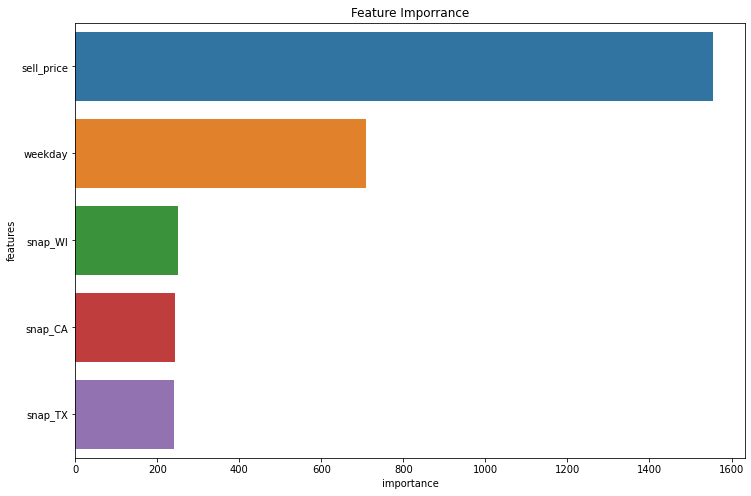

In [33]:
lgbm.visualize_feature_importance()